In [2]:
import pyart_utils as pu


import matplotlib
%matplotlib inline

import sys


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
import pandas as pd
import shapely.geometry
import geopandas as gpd

sys.path.append("../image")
import krige
import numpy as np
import pyart_plot_utils as ppu

In [6]:
import glob
night="2017-10-01"
next_night="2017-10-02"

In [7]:
def process_radar_csv(fname):
    csv_df = pd.read_csv(fname)
    del csv_df["Unnamed: 0"]
    start = fname.index('KOKX')
    csv_df['Date_Time'] = pd.to_datetime(fname[start+4:start+19],format='%Y%m%d_%H%M%S')
    return csv_df



on night 2017-09-12
2017-09/12 2017-09/13


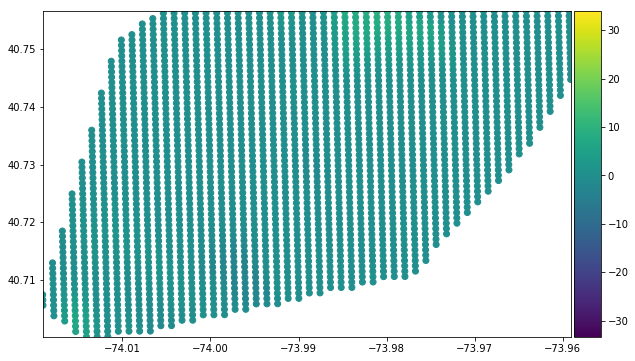

In [31]:
#nights = ["2017-09-28", "2017-09-29", "2017-09-30", "2017-10-01", "2017-10-02", "2017-10-03"]
nights = ["2017-09-12", "2017-09-13"]
for night, next_night in zip(nights, nights[1:]):
    print("on night {}".format(night))
    radar_dir = "-".join(night.split("-")[:2]) + "/" + night.split("-")[-1]
    next_radar_dir = "-".join(next_night.split("-")[:2]) + "/" + next_night.split("-")[-1]
    print(radar_dir, next_radar_dir)
    fnames = glob.glob("../radar/data/{}/*.filtered.csv".format(radar_dir))\
           + glob.glob("../radar/data/{}/*.filtered.csv".format(next_radar_dir))
    og_radar_levels = pd.concat((process_radar_csv(fname)\
                              for fname in fnames))

    t_filt = (og_radar_levels.Date_Time >= "{} 21:00".format(night)) &\
             (og_radar_levels.Date_Time <= "{} 06:00".format(next_night))
    og_radar_levels = og_radar_levels[t_filt]
    grouped = og_radar_levels.groupby(["lon", "lat"])
    radar_levels = grouped.apply(lambda g: g.set_index("Date_Time").dbzh.resample('10T').mean().reset_index())\
                          .reset_index()
    mgd = radar_levels

    mgd["geometry"] = mgd[["lon", "lat"]].apply(shapely.geometry.Point, axis=1)
    mgd_gdf = gpd.GeoDataFrame(mgd)
    mgd_mn = gpd.sjoin(mgd_gdf, krige.ch_df)
    def get_diffs(g):
        std = g.sort_values("Date_Time")
        diff_dbzh = std["dbzh"][1:].values - std["dbzh"][:-1].values
        return pd.DataFrame({"dbzh": diff_dbzh, 
                             "ts": std["Date_Time"][1:].values, 
                             "yy": std["lat"].values[1:],
                             "xx": std["lon"].values[1:]})
    grouped = mgd_mn.groupby(['lon', 'lat']).apply(get_diffs)
    rst = grouped.reset_index()
    rst["datetime"] = rst["ts"]
    anim = ppu.plot_video(rst)
    anim.save("diffs_{}.mp4".format(night))



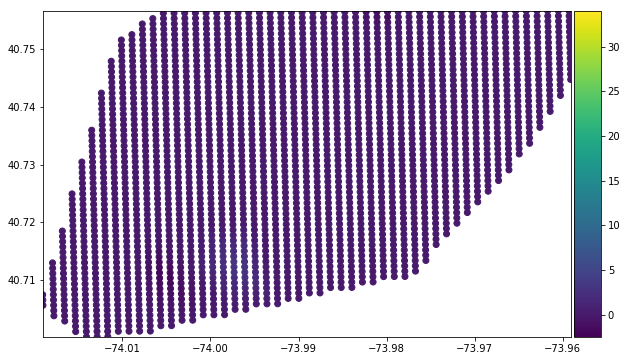

In [32]:
mgd_mn.head()
mgd_mn["datetime"] = mgd_mn["Date_Time"]
mgd_mn["xx"]= mgd_mn["lon"]
mgd_mn["yy"] = mgd_mn["lat"]
anim = ppu.plot_video(mgd_mn)
anim.save("radar_sep12.mp4".format(night))


grouped = og_radar_levels.groupby(["lon", "lat"])
radar_levels = grouped.apply(lambda g: g.set_index("Date_Time").dbzh.resample('10T').mean().reset_index())\
                   .reset_index()

In [11]:
mgd = radar_levels

In [12]:
import shapely.geometry
import geopandas as gpd

sys.path.append("../image")
import krige

mgd["geometry"] = mgd[["lon", "lat"]].apply(shapely.geometry.Point, axis=1)
mgd_gdf = gpd.GeoDataFrame(mgd)
mgd_mn = gpd.sjoin(mgd_gdf, krige.ch_df)

In [20]:
import numpy as np
def get_diffs(g):
    std = g.sort_values("Date_Time")
    diff_dbzh = std["dbzh"][1:].values - std["dbzh"][:-1].values
    return pd.DataFrame({"dbzh": diff_dbzh, 
                         "ts": std["Date_Time"][1:].values, 
                         "yy": std["lat"].values[1:],
                         "xx": std["lon"].values[1:]})
grouped = mgd_mn.groupby(['lon', 'lat']).apply(get_diffs)
rst = grouped.reset_index()
rst["datetime"] = rst["ts"]

In [21]:
import pyart_plot_utils as ppu

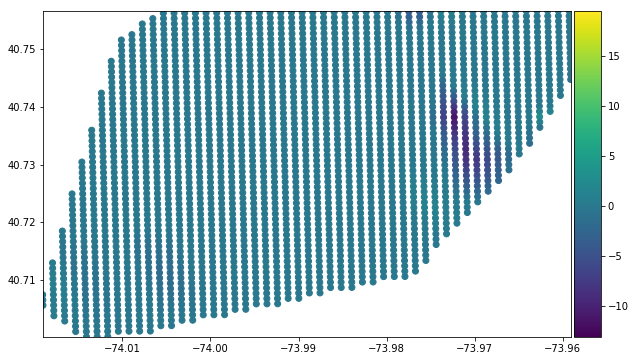

In [22]:
anim = ppu.plot_video(rst)